In [197]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mapping import Mapping

%load_ext version_information
%version_information numpy, pandas, matplotlib
%version_information
fig_prefix = "../figures/2018-07-22-jw-weaselball-starting_location_"
data_prefix = "../data/2018-07-22-jw-weaselball-starting_location_"


The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


In [198]:
df = pd.read_csv('../data/2018-07-22-jw-weaselball_analysis_translation_matrix_out.csv')
print(df.shape)
df = df.apply(pd.to_numeric)
df.head()

(6300, 6300)


,0,1,2,3,4,5,6,7,8,9,...,6290,6291,6292,6293,6294,6295,6296,6297,6298,6299
0,0.902985,0.007463,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.007463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.006944,0.902778,0.006944,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.005814,0.918605,0.005814,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.007353,0.897059,0.007353,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.006536,0.908497,0.006536,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
df_import_m = pd.read_csv('../data/2018-07-22-jw-weaselball_analysis_magnitude_vector_out.csv',  header=None);
magnitude_V = df_import_m.iloc[:,0]
magnitude_V = magnitude_V.apply(pd.to_numeric)
magnitude_V = magnitude_V.astype(float)
magnitude_V.head()

0    134.0
1    144.0
2    172.0
3    136.0
4    153.0
Name: 0, dtype: float64

In [200]:
NUMBER_OF_SQUARES = 100 #This should be a square number to create equal sized squares.
RESOLUTION_OF_S1 = 0.1 #This is used to discretize the yaw angle over 0 - 2*pi
START_X = 0
START_Y = 0
END_X = 9
END_Y = 9
END_YAW = 0
counter = 0

In [201]:
#The formula for mapping a 3D array to 1D is
#(z * xMax * yMax) + (y * xMax) + x;
#https://stackoverflow.com/questions/7367770/how-to-flatten-or-index-3d-array-in-1d-array
X_MAX = NUMBER_OF_SQUARES ** (1/2.0)
Y_MAX = NUMBER_OF_SQUARES ** (1/2.0)
YAW_MAX = (2 * np.pi) / RESOLUTION_OF_S1
mapping = Mapping(X_MAX, Y_MAX, YAW_MAX)#Fill in the logical areas that the system can reach (For now I am assuming it can go up/down 2 yaw states or the surronding (x,y) blocks)

In [202]:
#https://vknight.org/unpeudemath/code/2015/11/15/Visualising-markov-chains.html
#http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

In [203]:
#Use Dijkstras to find shortest path to goal
#https://gist.github.com/kachayev/5990802
from collections import defaultdict
from heapq import *

def dijkstra(edges, f, t):
    #Create dict to represent graph
    g = defaultdict(list)
    #add edges to dictionary
    for l,r,c in edges:
        g[l].append((c,r))


    q, seen, mins = [(1,f,())], set(), {f: 0}
    while q:
        (cost,v1,path) = heappop(q)
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            if v1 == t: return (cost, path)

            for c, v2 in g.get(v1, ()):
                if v2 in seen: continue
                prev = mins.get(v2, None)
                next = -abs(cost * c)
                if prev is None or next < prev:
                    mins[v2] = next
                    heappush(q, (next, v2, path))

    return (float("inf"),)

In [211]:
#Convert translation matrix into edges for graph
edges = []
total_runs = magnitude_V.sum()
for col in df.columns:
    for idx in df.index:
        if(df.loc[idx,col] != 0):
            edges.append((int(col), int(idx), -df.loc[idx,col] * (magnitude_V[idx]/total_runs)))


In [212]:

#
#
print "({},{},x) -> ({},{},{}):".format(START_X, START_Y, END_X, END_Y, END_YAW)
x = range(int(np.pi/RESOLUTION_OF_S1))
x_results = []
for i in x:
    x_results.append(dijkstra(edges, mapping.map3Dto1D(START_X,START_Y,i), mapping.map3Dto1D(END_X,END_Y,END_YAW)))
print(x_results)
(m,i) = min((v,i) for i,v in enumerate(x_results))
print "State {} to state {}".format(mapping.map3Dto1D(START_X,START_Y,i), mapping.map3Dto1D(END_X,END_Y,END_YAW))
print "Min is x = {} with P = {}".format(i,m)



(0,0,x) -> (9,9,0):
[(-6.786958723074438e-07, (99, (0, ()))), (-6.786958723074438e-07, (99, (100, ()))), (-6.786958723074438e-07, (99, (200, ()))), (-4.606280870871621e-13, (99, (189, (300, ())))), (-3.1262638137493073e-19, (99, (188, (289, (400, ()))))), (-2.1217823461357823e-25, (99, (188, (278, (389, (500, ())))))), (-1.44004492025716e-31, (99, (199, (308, (419, (510, (600, ()))))))), (-9.773525433158366e-38, (99, (188, (278, (377, (488, (589, (700, ())))))))), (-6.633251369376407e-44, (99, (199, (308, (419, (510, (599, (709, (800, ()))))))))), (-4.501960324373468e-50, (99, (188, (278, (377, (466, (577, (688, (799, (900, ())))))))))), (-3.055461889444154e-56, (99, (188, (278, (377, (466, (577, (687, (778, (889, (1000, ()))))))))))), (-2.073729372358451e-62, (99, (188, (278, (377, (486, (597, (698, (809, (900, (999, (1100, ())))))))))))), (-2.0737293723584487e-62, (99, (208, (317, (428, (538, (647, (758, (869, (979, (1089, (1200, ())))))))))))), (-1.4074315653023864e-68, (99, (199, (

In [213]:
#Take best path and make it into list of x,y,yaw points
import re
prob = m[0]
best_tuple = m[1]
best_list = re.findall(r'\d+', str(best_tuple))
best_list = map(int, best_list)
best_list = reversed(best_list)
best_list = map(mapping.map1Dto3D, best_list)
best_list

[(0, 0, 0), (9, 9, 0)]

In [214]:
#Turn (x,y,yaw) into lists that quiver likes X_start, Y_start, X_end, Y_end for all arrows
start_X = []
start_Y = []
end_X = []
end_Y = []
for i in range(len(best_list)-1):
    curr_tuple = best_list[i]
    next_tuple = best_list[i+1]
    start_X.append(curr_tuple[0])
    start_Y.append(curr_tuple[1])
    end_X.append(next_tuple[0])
    end_Y.append(next_tuple[1])

In [215]:
xvalues = np.array(range(int(X_MAX)))
yvalues = np.array(range(int(Y_MAX)))

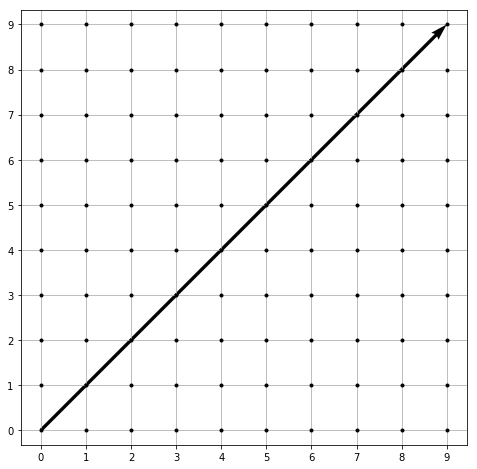

In [216]:
xx, yy = np.meshgrid(xvalues, yvalues)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.quiver(start_X, start_Y, end_X, end_Y, units = 'xy', scale = 1)
plt.axis('equal')
plt.xticks(range(10))
plt.yticks(range(10))

plt.grid()
plt.plot(xx, yy, marker='.', color='k', linestyle=' ')

In [218]:
#This tells us how often the 0 to 99 case occurs
print(df.iloc[0,99] * magnitude_V[0])


1.0
